# Credit Card Fraud Detection

In [19]:
# Credit Card Fraud Detection - Training Pipeline
# Step 1: Import Libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from imblearn.over_sampling import SMOTE
import joblib
import json

In [2]:
# Step 2: Load and Explore Data
def load_data(filepath='creditcard.csv'):
    """
    Load the credit card transaction dataset
    Dataset typically contains: Time, V1-V28 (PCA features), Amount, Class
    """
    df = pd.read_csv(filepath)
    print(f"Dataset shape: {df.shape}")
    print(f"Fraud cases: {df['Class'].sum()}")
    print(f"Valid cases: {len(df) - df['Class'].sum()}")
    return df


In [3]:
load_data()

Dataset shape: (284807, 31)
Fraud cases: 492
Valid cases: 284315


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [7]:
df = load_data()

Dataset shape: (284807, 31)
Fraud cases: 492
Valid cases: 284315


In [27]:
feature_names = df.columns.to_list()[:-1]
print(feature_names)

['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']


### Pre-Processing

In [4]:
# Step 3: Data Preprocessing function
def preprocess_data(df):
    """
    Preprocess the data:
    - Handle missing values
    - Scale features
    - Split into train/test
    """
    # Check for missing values
    print(f"Missing values: {df.isnull().sum().sum()}")
    
    # Separate features and target
    X = df.drop('Class', axis=1)
    y = df['Class']
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Scale features (important for fraud detection)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler


In [5]:
# Step 4: Handle Class Imbalance with SMOTE
def balance_dataset(X_train, y_train):
    """
    Apply SMOTE to handle imbalanced dataset
    Fraud cases are typically <1% of transactions
    """
    print("Original dataset shape:", X_train.shape)
    print("Original fraud ratio:", y_train.sum() / len(y_train))
    
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    
    print("Balanced dataset shape:", X_train_balanced.shape)
    print("Balanced fraud ratio:", y_train_balanced.sum() / len(y_train_balanced))
    
    return X_train_balanced, y_train_balanced


In [8]:
X_train, X_test, y_train, y_test, scaler = preprocess_data(df)

Missing values: 0


In [9]:
X_train_balanced, y_train_balanced = balance_dataset(X_train, y_train)

Original dataset shape: (227845, 30)
Original fraud ratio: 0.001729245759178389
Balanced dataset shape: (454902, 30)
Balanced fraud ratio: 0.5


### Modelling

In [6]:
# Step 5: Train the Model
def train_model(X_train, y_train):
    """
    Train Random Forest Classifier
    Could also use XGBoost, LightGBM, or Neural Networks
    """
    print("Training Random Forest model...")
    
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'  # Additional handling for imbalance
    )
    
    model.fit(X_train, y_train)
    print("Training completed!")
    
    return model


In [10]:
model = train_model(X_train_balanced, y_train_balanced)

Training Random Forest model...
Training completed!


In [14]:
y_pred = model.predict(X_test)
print(y_pred)

[0 0 0 ... 0 0 0]


In [15]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
print(y_pred_proba)

[0.01516913 0.03245917 0.05314225 ... 0.00767669 0.00855105 0.01991104]


In [30]:
def create_performance_report(y_test, y_pred):
    """Print detailed classification report"""
    print("\n" + "="*60)
    print("DETAILED CLASSIFICATION REPORT")
    print("="*60)
    print(classification_report(y_test, y_pred, 
                                target_names=['Legitimate', 'Fraud'],
                                digits=3))

In [31]:
create_performance_report(y_test,y_pred)


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

  Legitimate      1.000     0.998     0.999     56864
       Fraud      0.408     0.857     0.553        98

    accuracy                          0.998     56962
   macro avg      0.704     0.927     0.776     56962
weighted avg      0.999     0.998     0.998     56962



## Visualization

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 5)

In [13]:
def visualize_confusion_matrix(y_test, y_pred):
    """
    Visualization 1: Confusion Matrix Heatmap
    Shows True Positives, False Positives, True Negatives, False Negatives
    """
    cm = confusion_matrix(y_test, y_pred)
    
    plt.subplot(1, 3, 1)
    
    # Create heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                cbar=True, square=True, linewidths=2,
                annot_kws={'size': 16, 'weight': 'bold'})
    
    plt.title('Confusion Matrix\n', fontsize=14, fontweight='bold')
    plt.ylabel('Actual Class', fontsize=12, fontweight='bold')
    plt.xlabel('Predicted Class', fontsize=12, fontweight='bold')
    
    # Add labels
    plt.xticks([0.5, 1.5], ['Legitimate', 'Fraud'])
    plt.yticks([0.5, 1.5], ['Legitimate', 'Fraud'], rotation=0)
    
    # Calculate metrics
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Add text box with metrics
    textstr = f'Accuracy: {accuracy:.3f}\nPrecision: {precision:.3f}\nRecall: {recall:.3f}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    plt.text(1.02, 0.5, textstr, transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='center', bbox=props)
    
    print(f"\nConfusion Matrix Metrics:")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")



Confusion Matrix Metrics:
True Negatives (TN): 56742
False Positives (FP): 122
False Negatives (FN): 14
True Positives (TP): 84
Accuracy: 0.998
Precision: 0.408
Recall: 0.857


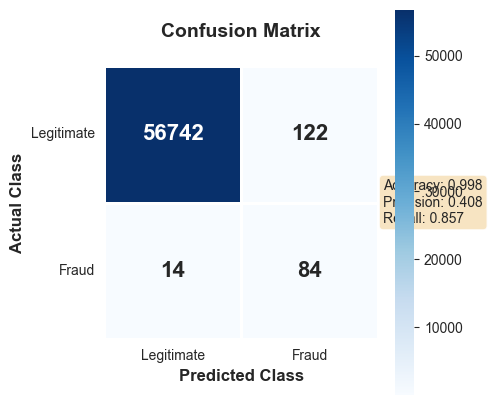

In [16]:
visualize_confusion_matrix(y_test, y_pred)

In [20]:
def visualize_roc_curve(y_test, y_pred_proba):
    """
    Visualization 2: ROC Curve with AUC Score
    Shows model's ability to distinguish between classes
    """
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.subplot(1, 3, 2)
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color='darkorange', lw=3, 
             label=f'ROC Curve (AUC = {roc_auc:.3f})')
    
    # Plot diagonal reference line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random Classifier')
    
    # Styling
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.title('ROC Curve\n', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Add shaded area under curve
    plt.fill_between(fpr, tpr, alpha=0.2, color='darkorange')
    
    # Add annotation for optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    plt.plot(fpr[optimal_idx], tpr[optimal_idx], 'ro', markersize=10,
             label=f'Optimal Threshold: {optimal_threshold:.3f}')
    plt.legend(loc="lower right", fontsize=9)
    
    print(f"\nROC-AUC Score: {roc_auc:.3f}")
    print(f"Optimal Threshold: {optimal_threshold:.3f}")



ROC-AUC Score: 0.981
Optimal Threshold: 0.161


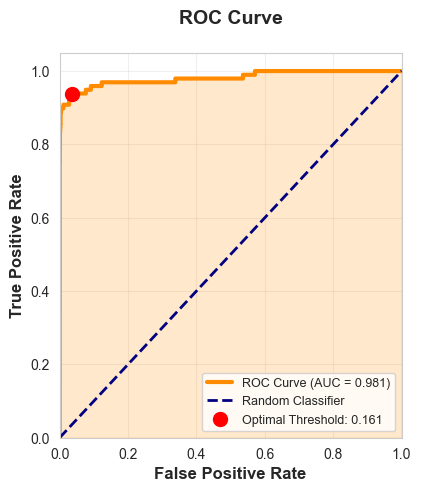

In [21]:
visualize_roc_curve(y_test, y_pred_proba)

In [22]:
def visualize_feature_importance(model, feature_names):
    """
    Visualization 3: Feature Importance Bar Chart
    Shows which features are most important for predictions
    """
    # Get feature importances
    importances = model.feature_importances_
    
    # Get top 15 features
    indices = np.argsort(importances)[-15:]
    top_features = [feature_names[i] for i in indices]
    top_importances = importances[indices]
    
    plt.subplot(1, 3, 3)
    
    # Create horizontal bar chart
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features)))
    bars = plt.barh(range(len(top_features)), top_importances, color=colors)
    
    # Add value labels on bars
    for i, (bar, importance) in enumerate(zip(bars, top_importances)):
        plt.text(importance + 0.001, i, f'{importance:.4f}', 
                va='center', fontsize=8)
    
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')
    plt.title('Top 15 Feature Importances\n', fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    
    # Add a vertical line at mean importance
    mean_importance = np.mean(top_importances)
    plt.axvline(mean_importance, color='red', linestyle='--', 
                linewidth=2, alpha=0.7, label=f'Mean: {mean_importance:.4f}')
    plt.legend(fontsize=9)
    
    print(f"\nTop 5 Most Important Features:")
    for i in range(min(5, len(top_features))):
        print(f"{i+1}. {top_features[-(i+1)]}: {top_importances[-(i+1)]:.4f}")



Top 5 Most Important Features:
1. V14: 0.2041
2. V4: 0.1138
3. V10: 0.1121
4. V12: 0.1022
5. V17: 0.0892


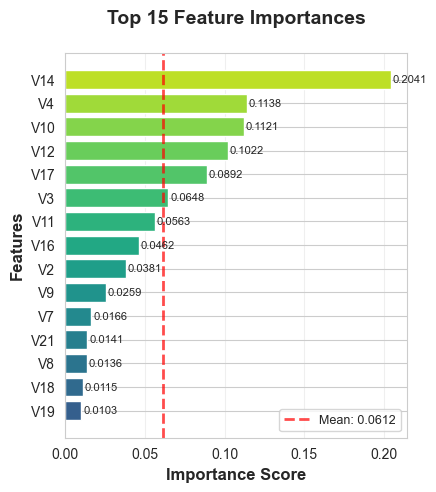

In [28]:
visualize_feature_importance(model, feature_names)